# Functions to get the Aggregates Volumes

In [ ]:
import requests
import json
import matplotlib.pyplot as plt
import datetime
import matplotlib.pyplot as plt

def fetch_aggregated_volumes(ticker, start_date, end_date):
    """
    Fetches aggregated volumes for the given stock ticker and date range.

    Args:
    - ticker (str): The stock ticker symbol.
    - start_date (str): The start date in the format 'YYYY-MM-DD'.
    - end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
    - dict: A dictionary containing aggregated volumes with timestamps as keys.
    """
    # API query parameters
    api_key = "RLH5skiQVl24hXBE2IyPT3JBDmorI4r0"

    readable_timestamps = [
        '00:00', '00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', 
        '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', 
        '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', 
        '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', 
        '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', 
        '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', 
        '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', 
        '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', 
        '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', 
        '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', 
        '22:30', '22:45', '23:00', '23:15', '23:30', '23:45'
    ]


    # Initialize a dictionary to store volumes for each timestamp
    volume_data = {timestamp: {'volumes': [], 'num_trades': []} for timestamp in readable_timestamps}


    # Construct API query URL
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/15/minute/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"

    # Make the API request
    response = requests.get(url)
    average_volumes = {}

    # Check if the request was successful
    if response.status_code == 200:
        # Load JSON data from the response
        data = response.json()
        results = data["results"]
        # List to store readable timestamps
        readable_timestamps = []

        # Iterate through results and convert timestamps to readable times
        for result in results:
            timestamp = result["t"]
            volume = result["v"]
            num_trades = result["n"]
            timestamp_et = pd.to_datetime(timestamp, unit='ms', utc=True).tz_convert('America/New_York')
            timestamp_str = timestamp_et.strftime("%H:%M")
            volume_data[timestamp_str]['volumes'].append(volume)
            volume_data[timestamp_str]['num_trades'].append(num_trades)
          

        # Get the aggregated volumes
        for timestamp, data in volume_data.items():
            if len(data['volumes']) > 0:
                average_volume = sum(data['volumes']) / len(data['volumes'])
                average_trades = sum(data['num_trades']) / len(data['num_trades'])
                average_volumes[timestamp] = {"volume": average_volume, "num_trades": average_trades}

    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
    return average_volumes

def plot_volume_histogram(volumes):
    """
    Plots a histogram of average volumes and number of trades for each 15-minute interval of the day.

    Args:
    - volumes (dict): A dictionary containing average volumes and number of trades with timestamps as keys.
    """
    timestamps = list(volumes.keys())
    average_volume = [data["volume"] for data in volumes.values()]
    average_trades = [data["num_trades"] for data in volumes.values()]

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the volume histogram
    ax.bar(timestamps, average_volume, width=0.4, color='skyblue', label='Average Volume')

    # Plot the number of trades histogram on top of the volume histogram
    ax.bar(timestamps, average_trades, width=0.4, color='orange', alpha=0.7, label='Average Trades')

    # Set labels and title
    ax.set_xlabel('Time of the Day (HH:MM)')
    ax.set_ylabel('Average Volume / Number of Trades')
    ax.set_title(f'Average Volume and Number of Trades for Each 15-minute Interval of the Day - {ticker}')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Add legend
    plt.legend()

    # Show grid
    plt.grid(axis='y')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Plot the Values

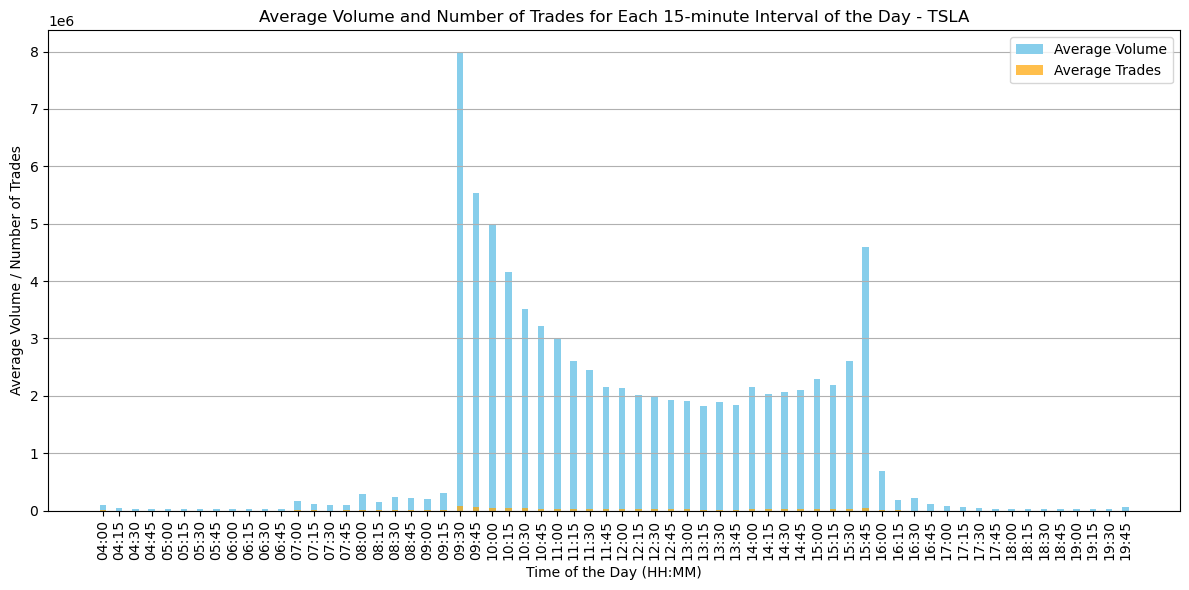

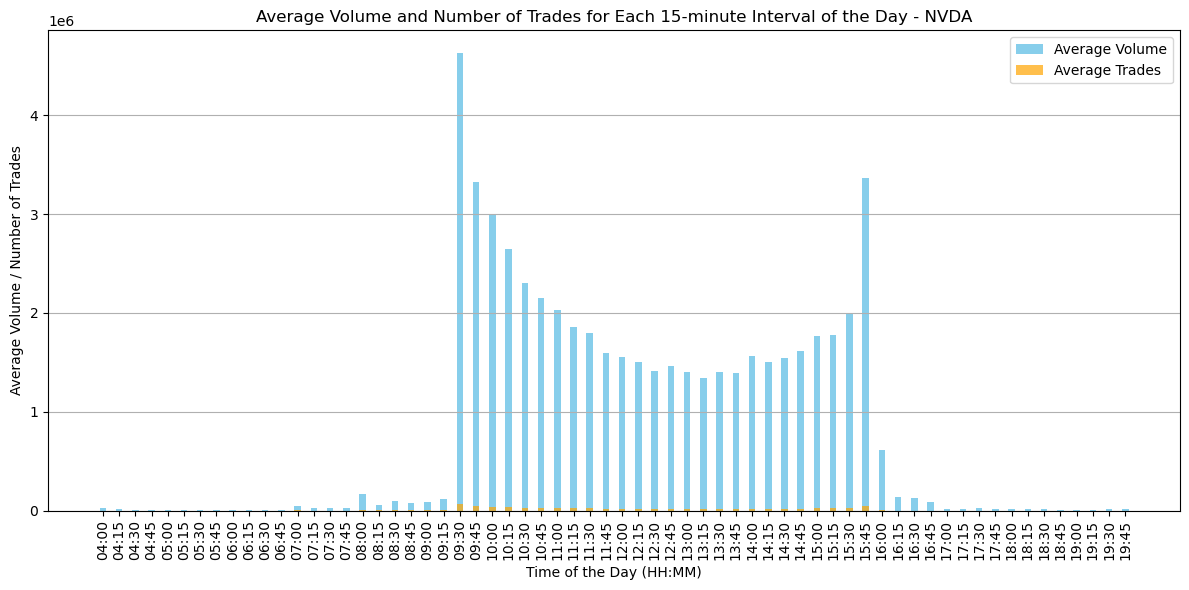

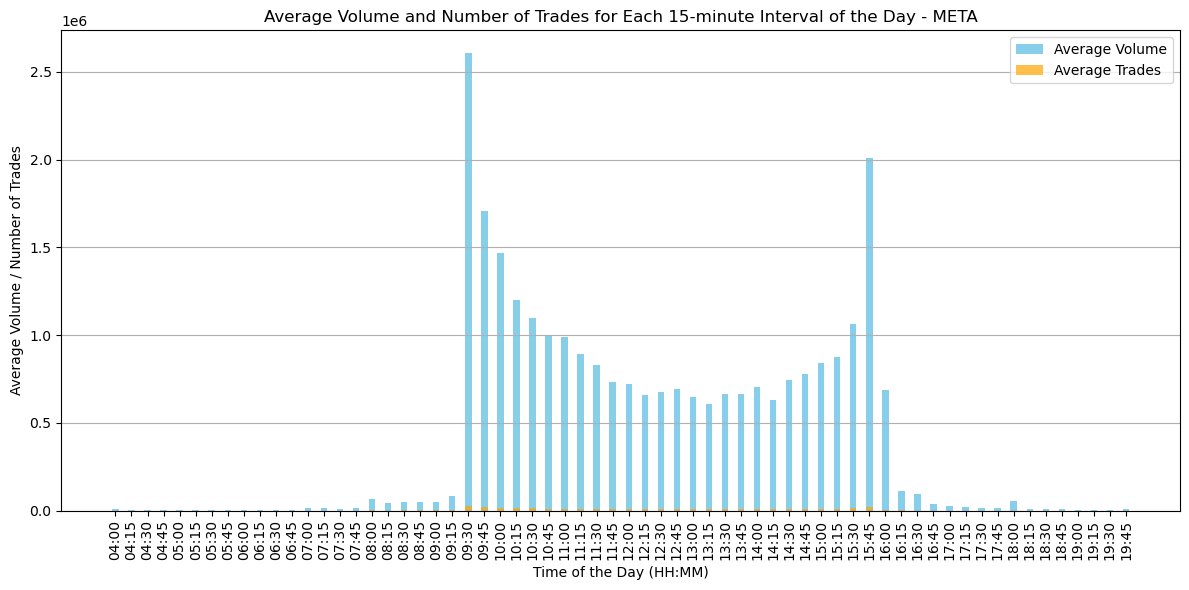

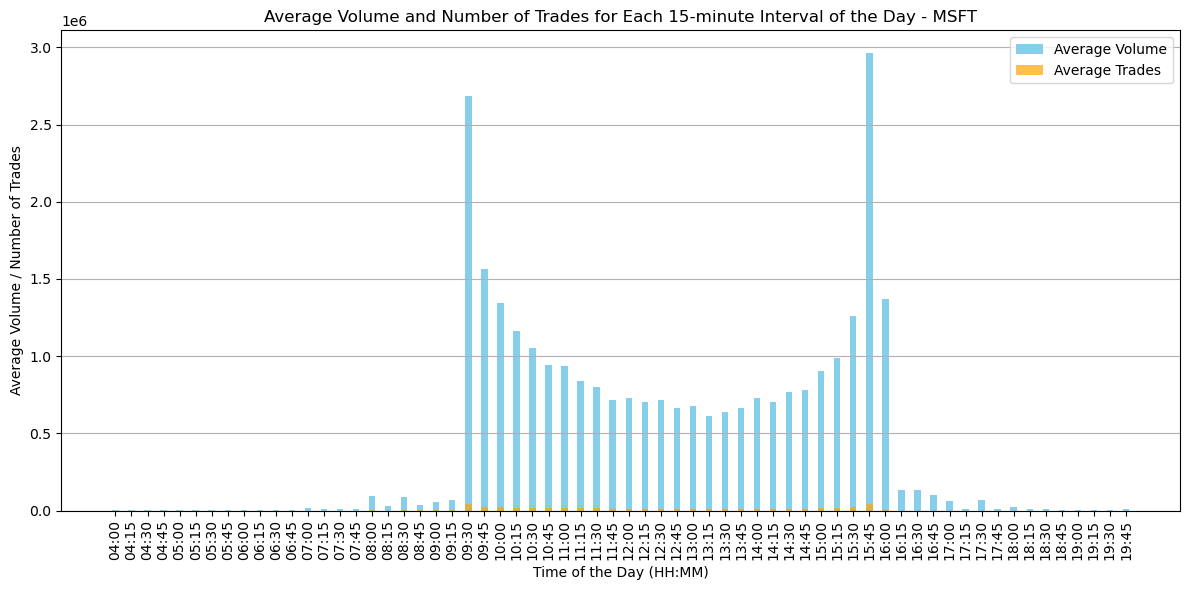

In [207]:
start_date = "2023-01-01"
end_date =  "2024-02-16"
high_vol = ['TSLA', 'NVDA', 'META', 'MSFT']
for ticker in high_vol:
    volumes = fetch_aggregated_volumes(ticker, start_date, end_date)
    plot_volume_histogram(volumes)

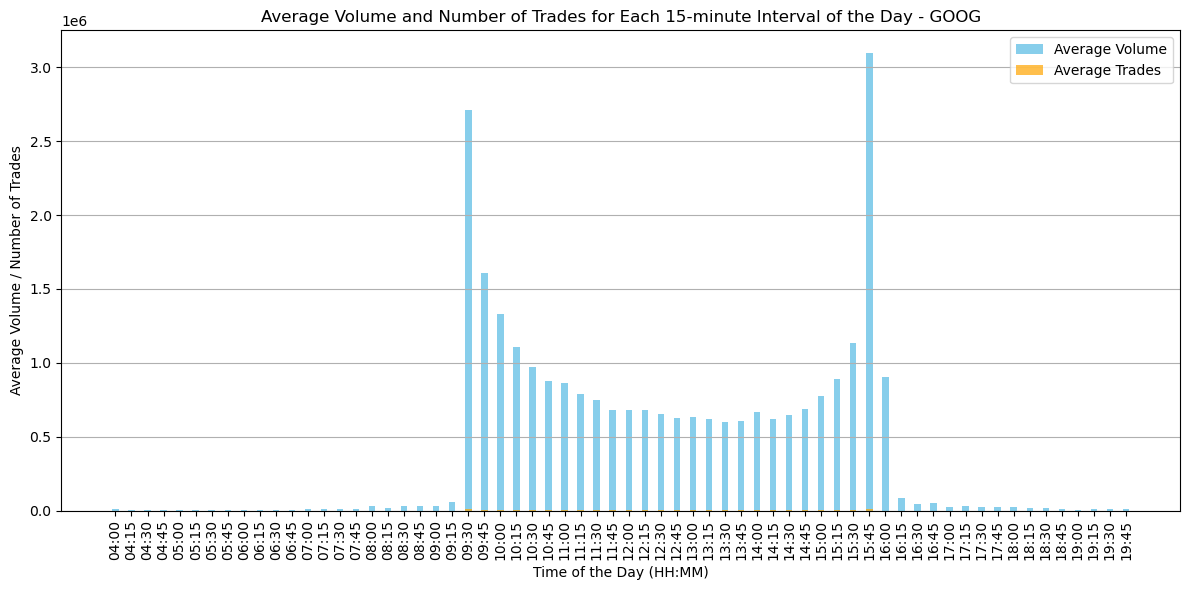

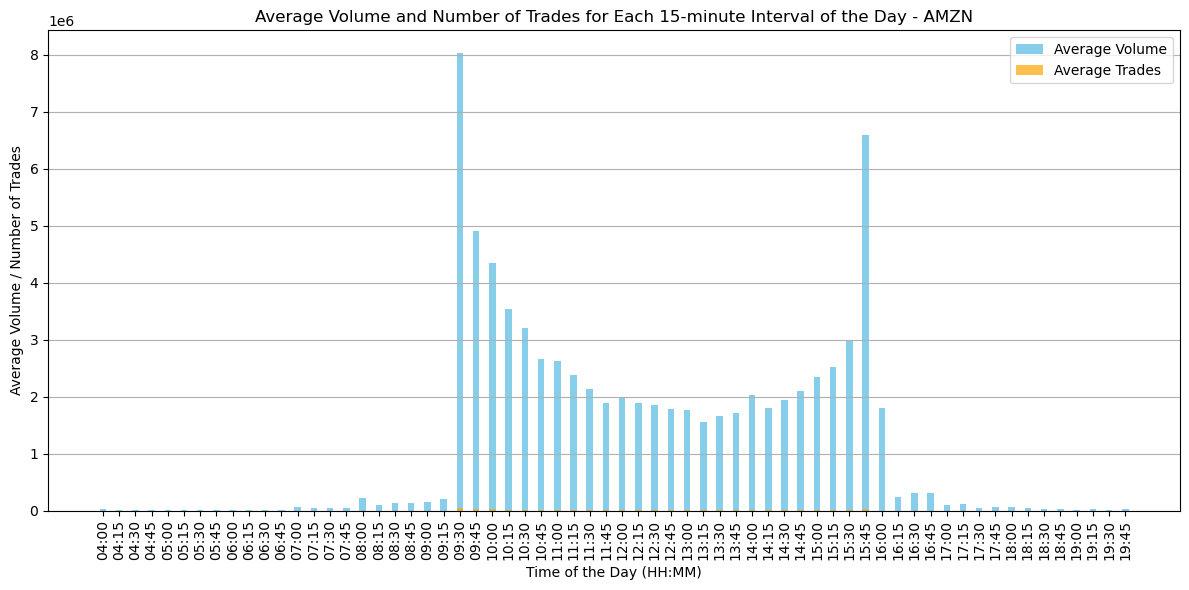

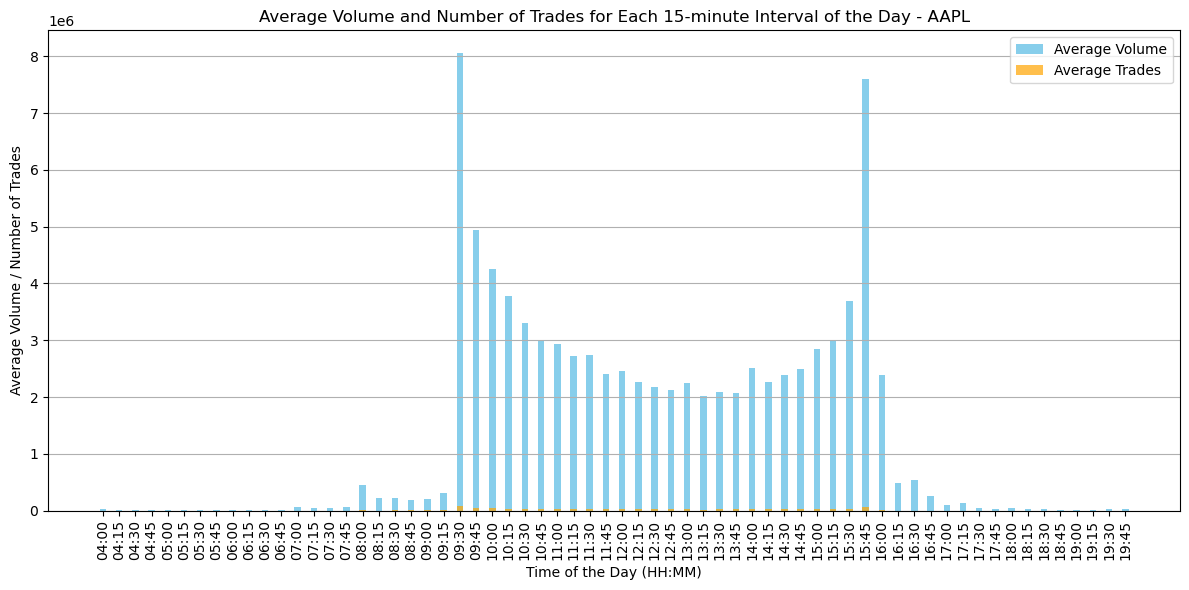

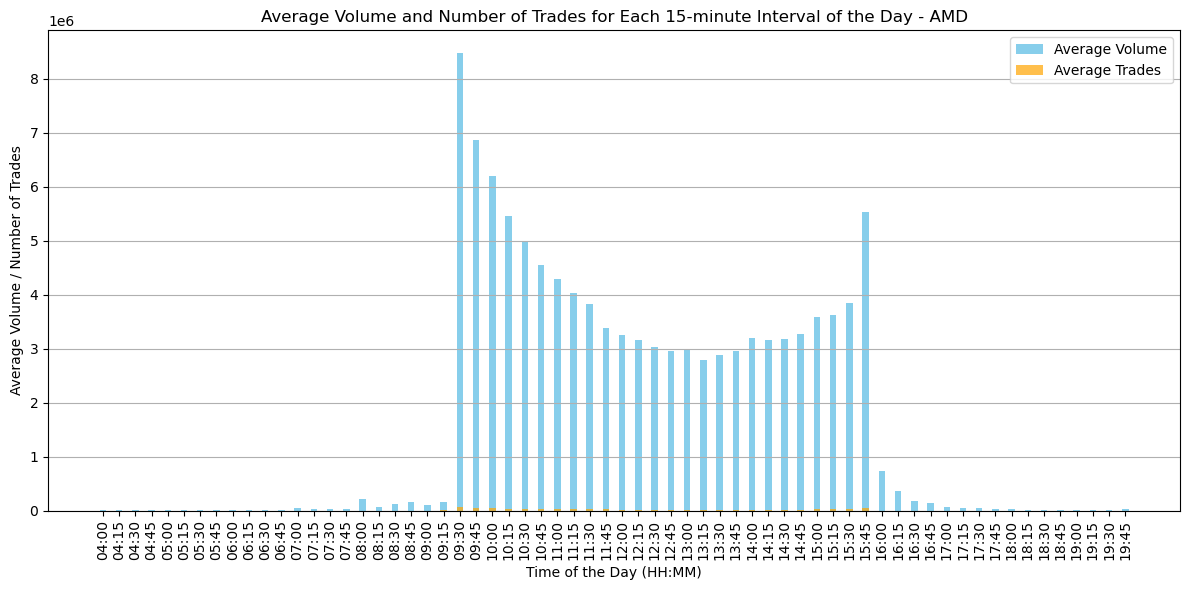

In [204]:
low_vol = ['GOOG', 'AMZN', 'AAPL', 'AMD']
for ticker in low_vol:
    volumes = fetch_aggregated_volumes(ticker, start_date, end_date)
    plot_volume_histogram(volumes)

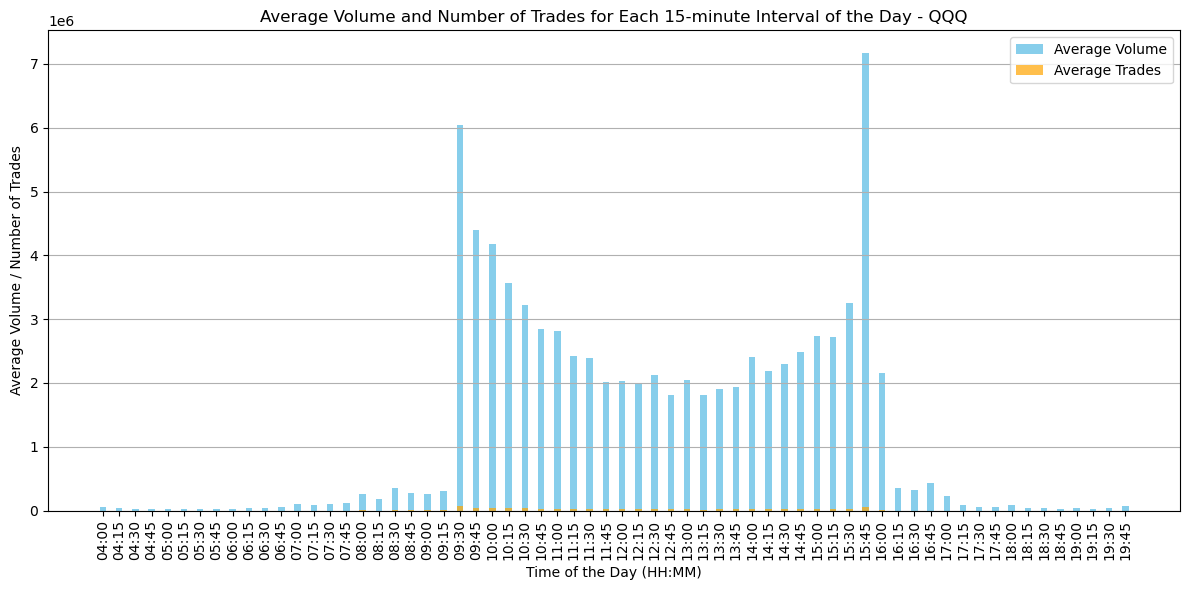

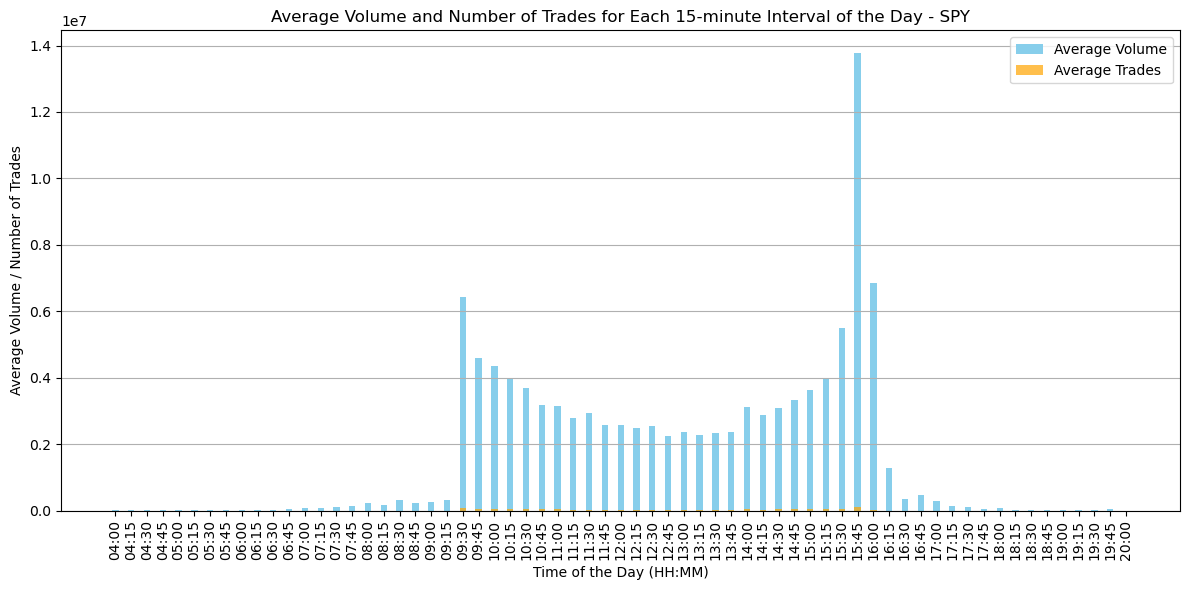

In [210]:
etf = ['QQQ', 'SPY']
for ticker in etf:
    volumes = fetch_aggregated_volumes(ticker, start_date, end_date)
    plot_volume_histogram(volumes)

# Analyze the Significant Times

In [201]:
import numpy as np

def analyze_volumes(volumes, threshold):
    """
    Analyzes the volumes and number of trades for each 15-minute interval and returns times above a certain threshold.

    Args:
    - volumes (dict): A dictionary containing average volumes and number of trades with timestamps as keys.
    - threshold (float): The absolute threshold value for both volume and trades significance.

    Returns:
    - list: A list of timestamps where both volume and trades significance are above the threshold.
    """
    significant_times = []

    # Extract the average volumes and number of trades from the input dictionary
    average_volume = np.array([data["volume"] for data in volumes.values() if data["volume"] is not None])
    average_trades = np.array([data["num_trades"] for data in volumes.values() if data["num_trades"] is not None])

    if len(average_volume) == 0 or len(average_trades) == 0:
        return significant_times  # Return empty list if no data available

    # Calculate overall average and standard deviation
    overall_average_volume = np.mean(average_volume)
    overall_std_volume = np.std(average_volume)
    overall_average_trades = np.mean(average_trades)
    overall_std_trades = np.std(average_trades)

    # Calculate statistical significance for each interval
    volume_significance = (average_volume - overall_average_volume) / overall_std_volume
    trades_significance = (average_trades - overall_average_trades) / overall_std_trades

    # Check if both volume and trades significance are above the threshold and add corresponding times to the list
    for i, timestamp in enumerate(volumes.keys()):
        if abs(volume_significance[i]) > threshold and abs(trades_significance[i]) > threshold:
            significant_times.append(timestamp)

    return significant_times

In [197]:
high_vol = ['TSLA', 'NVDA', 'META', 'MSFT']
for ticker in high_vol:
    volumes = fetch_aggregated_volumes(ticker, start_date, end_date)
    stats = analyze_volumes(volumes, 1.5)
    print("significant times for " + ticker)
    print(stats)

significant times for TSLA
['09:30', '09:45', '10:00', '10:15', '15:45']
significant times for NVDA
['09:30', '09:45', '10:00', '10:15', '15:45']
significant times for META
['09:30', '09:45', '10:00', '15:45']
significant times for MSFT
['09:30', '09:45', '15:45']


In [205]:
low_vol = ['GOOG', 'AMZN', 'AAPL', 'AMD']
for ticker in low_vol:
    volumes = fetch_aggregated_volumes(ticker, start_date, end_date)
    stats = analyze_volumes(volumes, 1.5)
    print("significant times for " + ticker)
    print(stats)

significant times for GOOG
['09:30', '09:45', '15:45']
significant times for AMZN
['09:30', '09:45', '10:00', '15:45']
significant times for AAPL
['09:30', '09:45', '10:00', '15:45']
significant times for AMD
['09:30', '09:45', '10:00', '10:15', '15:45']


In [202]:
etf = ['QQQ', 'SPY']
for ticker in etf:
    volumes = fetch_aggregated_volumes(ticker, start_date, end_date)
    stats = analyze_volumes(volumes, 1.5)
    print("significant times for " + ticker)
    print(stats)

significant times for QQQ
['09:30', '09:45', '10:00', '15:45']
significant times for SPY
['09:30', '15:30', '15:45']


# Save the Data to CSV Files

In [ ]:
import requests
import csv
import pandas as pd
import time

def fetch_aggregated_volumes(ticker, start_date, end_date):
    """
    Fetches aggregated volumes for the given stock ticker and date range.

    Args:
    - ticker (str): The stock ticker symbol.
    - start_date (str): The start date in the format 'YYYY-MM-DD'.
    - end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
    - pd.DataFrame: A DataFrame containing aggregated volumes with timestamps as index.
    """
    # API query parameters
    api_key = "RLH5skiQVl24hXBE2IyPT3JBDmorI4r0"
    interval_minutes = 15  # Assuming interval of 15 minutes
    
    # Initialize an empty list to store data
    data_list = []

    # Initialize a dictionary to store volumes for each timestamp
    volume_data = {}
    # Construct initial API query URL
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/15/minute/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    params = {
            'apiKey': api_key
        }
    # Fetch data until end date or no more next_url
    while url:
        # Make the API request
        response = requests.get(url, params=params)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Load JSON data from the response
            data = response.json()
            results = data["results"]

            # Iterate through results and convert timestamps to readable times
            for result in results:
                timestamp = result["t"]
                volume = result["v"]
                num_trades = result["n"]
                timestamp_et = pd.to_datetime(timestamp, unit='ms', utc=True).tz_convert('America/New_York')
                timestamp_str = timestamp_et.strftime("%Y-%m-%d %H:%M:%S")
                volume_data[timestamp_str] = {"volume": volume, "num_trades": num_trades}

            # Update URL for next page if available
            url = data.get('next_url')

            # Delay to comply with rate limit (5 requests per minute)
            time.sleep(12)  # Sleep for 12 seconds between each request

        else:
            print(f"Failed to fetch data. Status code: {response.status_code}")
            break

    # Convert dictionary to DataFrame
    df = pd.DataFrame(volume_data).T

    # Save DataFrame to CSV
    df.to_csv(f"{ticker}_aggregated_volumes.csv")

    return df